# Block pseudoinversion
Here we analyse the formula of block pseudoinversion we have got. 

## Introduction
Because in Data Analysis and ML [6,7] we often have linear independent sets of data (historical data or neural net's weights) we can consider only that case. So, let the $A$ be a matrix of *full column rank*. That means it satisfies the condition $A^+A=E$, where $A^+$ - the pseudoinversed (Moore-Penrose inversion) matrix [1].

The pseudoinversed matrix can be found with one of the following methods: 
1. using SVD decomposition: $A = USV^* \implies A^+ = VS^+U^* $. This method is used in _pinv_ method in the standard math libraries [2,3]. The computational complexity is $O(mn^2)$;
2. using the Grevile's algorithm [4]. In our full-rank case, the computational complexity is about $O(mn^2)$;
3. using the _Hermitian_ formula: $A^+=(A^*A)^{-1}A^*$. The computational complexity is $O(mn^2)$. This formula can be used only for full-column rank matrices. P.S. The name _Hermitian_ is not common, but we refer to this formula a lot and we introduced that name.
4. Clines formula for block matrices [5].


## Our method
In this research, we get the new formula for finding pseudoinversed matrix:

$$A^+ = [A_1 A_2 \dots A_n]^+=\begin{bmatrix}
        \begin{bmatrix}
            A_1^+ \\
            A_2^+ \\
            \dots \\
            A_n^+ \\
        \end{bmatrix}
        [A_1 A_2 \dots A_n]
    \end{bmatrix}^{-1}      \begin{bmatrix}
            A_1^+ \\
            A_2^+ \\
            \dots \\
            A_n^+ \\
        \end{bmatrix} = \begin{bmatrix}
            E & A_1^+A_2 & \dots & A_1^+A_n \\
            A_2^+A_1 & E &  \dots & A_2^+A_n \\
            \dots & \dots &  \dots & \dots \\
            A_n^+A_1 & A_n^+A_1 &  \dots &  E \\
        \end{bmatrix}^{-1}
         \begin{bmatrix}
            A_1^+ \\
            A_2^+ \\
            \dots \\
            A_n^+ \\
        \end{bmatrix}
        .$$


This is a Moore-Penrose pseudounversed matrix (we have the proof). But it has some valuable *advantages*. 
- First of all, it's the generalization of Grevile's algorithm, and the generalization of the _Hermitian_ formula as well (we also have the proofs).
- It requires inversing smaller blocks, which is more effective from the calculation time perspective
- We can see that the formula is very parallelizable. We split the big matrix into a few small submatrices and multiply them in parallel. The computational advantage increases with increasing the width of the matrix (amount of columns).
- It has a big computational advantage when the pseudoinversed for blocks are known. For example, we have already trained model. And new data comes. Or we decided to add the hidden layer to the neural network [7]. Then the recalculation of new weight requires much less resources than training it again.  
  


## References
1. [Regression and the Moore-Penrose pseudoinverse, Albert, A., Elsevier (1972)](https://cds.cern.ch/record/1253778/export/hx)
2. [Matlab pinv documentation](https://de.mathworks.com/help/matlab/ref/pinv.html#mw_ffa95973-29a2-48a1-adb0-5a4214e0d9cf)
3. [Numpy pinv documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html)
4. T.N.E. Grevile Some applications of the pseudo-inverse of matrix SIAM Rev. (1960)
5. R.E. Cline, Representation for the generalized inverse of a partitioned matrix, J.Soc. Industr. Appl. Math., 12 (1964), 588–600.
6. [J. Tapson and A. van Schaik, Learning the Pseudoinverse Solution to Network Weights](https://arxiv.org/pdf/1207.3368.pdf)
7. [Matthias Kissel; Klaus Diepold, Convolutional Neural Networks with analytically determined Filters](https://ieeexplore.ieee.org/abstract/document/9891906/figures#figures)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
%run binv.ipynb import binv

##  Сomparison our formula _binv_ with _numpy.linalg.pinv_

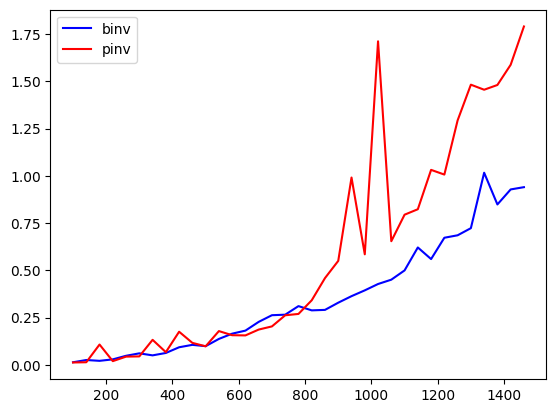

In [7]:
rows_amount = []
train_time_in_parallel = []
train_time_in_one_thread = []

rows = 100
while rows < 1_500:
  rows_amount.append(rows)
  columns = rows
  check_matrix = np.random.rand(columns, rows)

  gc.collect()

  start = time.time()
  pinv(check_matrix)
  finish = time.time()
  train_time_in_one_thread.append(finish - start)

  gc.collect()

  start = time.time()
  binv(check_matrix, columns // 10)
  finish = time.time()
  train_time_in_parallel.append(finish - start)

  rows += 40

plt.plot(rows_amount, train_time_in_parallel, "-b", label="binv")
plt.plot(rows_amount, train_time_in_one_thread, "-r", label="pinv")
plt.legend(loc="upper left")
plt.show()

We can see that the computational advantage of _binv_ is increasing with the matrix size. But this result is gotten with simplest using _python.ThreadPool_ parallelization which requires a lof of context changing. Programming with CUDA or MPI will boost the calculation dramatically. 


### Draft for future  

Also, the matrix in the main formula could be rewritten using the following formulas:
1. $(A+B)^+ = (A^+B + B^+A + 2E)^{-1}(A^+ + B^+)$ (it requires to inverse only small blocks, which is more preferable)
2. ...